# Imports & Settings

In [52]:
import numpy as np
import pandas as pd
import yfinance as yf

# Visualization tools
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# Data Gathering
## S&P 500 Constituents

In [2]:
snp = pd.read_csv('../data/sp500.csv')
snp.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [3]:
snp_tickers = snp.Symbol.values.tolist()

## Price Histories

In [7]:
prices = yf.download(snp_tickers, group_by='tickers', period='max')

[*********************100%***********************]  505 of 505 completed

1 Failed download:
- BF.B: 1d data not available for startTime=-2208988800 and endTime=1629577039. Only 100 years worth of day granularity data are allowed to be fetched per request.


It appears that the ticker `BF.B` failed. The '.B' portion of the ticker refers to the specific share class of the security. Referencing the share class in a ticker is not fully standardized across different financial sources and can sometimes be represented as a hyphen instead of a period. I will try to download the data for `BF.B` by manually changing it to `BF-B` instead.

In [8]:
bfb = yf.download(tickers='BF-B', period='max')

[*********************100%***********************]  1 of 1 completed


In [10]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15014 entries, 1962-01-02 to 2021-08-20
Columns: 3030 entries, ('COST', 'Open') to ('ZION', 'Volume')
dtypes: float64(3030)
memory usage: 347.2 MB


The data returned by the `yfinance.download()` function placed everything into a single dataframe with columns grouped by ticker. While useful for quickly analyzing / plotting any of the companies' histories, there are two primary issues with having everything in one dataframe:
- The file is much larger than the 100MB limit imposed by GitHub. While solutions for handling large file uploads exist, it's preferable to avoid such workarounds unless absolutely needed.
- Thinking forward to the interactive dashboard portion of this project, loading in all of the price history data for every company in the S&P 500 whenever we want to analyze just one is a waste of resources and will likely lead to unwanted load times.

By splitting the data up into individual files, both of these issues are resolved. To start, I'll export the `BF.B` / `BF-B` dataframe and then move on to looping over all of the others.

In [11]:
bfb.to_csv('../data/price_histories/BF-B_history.csv')
print('Successfully saved BF-B\'s history.')

Successfully saved BF-B's history.


In [16]:
for i, ticker in enumerate(snp_tickers):
    if ticker == 'BF.B':
        continue
    df = prices[ticker].dropna()
    df.to_csv(f'../data/price_histories/{ticker}_history.csv')
    print(f'{ticker.ljust(5)} -- {i+1} / {len(snp_tickers)} completed', end='\r')

## Fundamental Data

### Income Statement

In [12]:
df_income = pd.read_csv('../data/simfin/us-income-quarterly.csv', 
                        delimiter=';', 
                        parse_dates=['Report Date', 'Publish Date', 'Restated Date'])
df_income.head()

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period,Report Date,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),...,Non-Operating Income (Loss),"Interest Expense, Net","Pretax Income (Loss), Adj.",Abnormal Gains (Losses),Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Extraordinary Gains (Losses),Net Income,Net Income (Common)
0,A,45846,USD,2010,Q3,2010-07-31,2010-10-06,2011-09-07,347000000.0,352000000.0,...,-15000000.0,-21000000.0,100000000,127000000.0,227000000,-22000000.0,205000000,NaN,205000000,205000000
1,A,45846,USD,2010,Q4,2010-10-31,2010-12-20,2012-12-20,344000000.0,356000000.0,...,35000000.0,-16000000.0,238000000,5000000.0,243000000,49000000.0,292000000,NaN,292000000,292000000
2,A,45846,USD,2011,Q1,2011-01-31,2011-03-09,2012-03-05,347000000.0,355000000.0,...,-13000000.0,-19000000.0,198000000,NaN,198000000,-5000000.0,193000000,NaN,193000000,193000000
3,A,45846,USD,2011,Q2,2011-04-30,2011-06-07,2012-06-04,347000000.0,355000000.0,...,-6000000.0,-17000000.0,260000000,NaN,260000000,-60000000.0,200000000,NaN,200000000,200000000
4,A,45846,USD,2011,Q3,2011-07-31,2011-09-07,2012-09-05,348000000.0,357000000.0,...,0.0,-17000000.0,281000000,NaN,281000000,49000000.0,330000000,NaN,330000000,330000000


In [13]:
df_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64471 entries, 0 to 64470
Data columns (total 28 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Ticker                                    64471 non-null  object        
 1   SimFinId                                  64471 non-null  int64         
 2   Currency                                  64471 non-null  object        
 3   Fiscal Year                               64471 non-null  int64         
 4   Fiscal Period                             64471 non-null  object        
 5   Report Date                               64471 non-null  datetime64[ns]
 6   Publish Date                              64471 non-null  datetime64[ns]
 7   Restated Date                             64471 non-null  datetime64[ns]
 8   Shares (Basic)                            63932 non-null  float64       
 9   Shares (Diluted)            

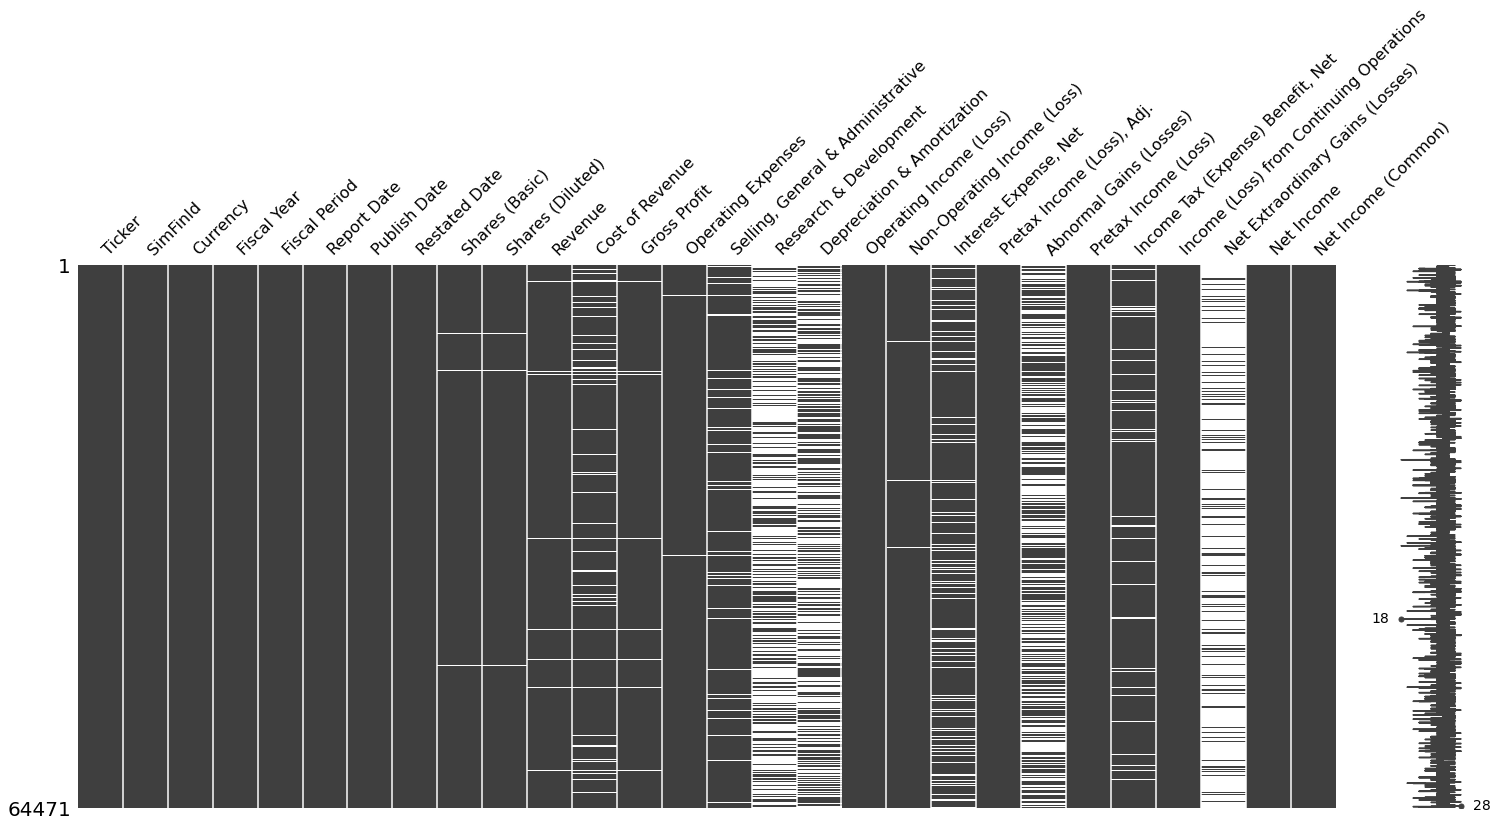

In [25]:
msno.matrix(df_income);

### Balance Sheet

In [10]:
df_balance = pd.read_csv('../data/simfin/us-balance-quarterly.csv', 
                         delimiter=';', 
                         parse_dates=['Report Date', 'Publish Date', 'Restated Date'])
df_balance.head()

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period,Report Date,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),...,Short Term Debt,Total Current Liabilities,Long Term Debt,Total Noncurrent Liabilities,Total Liabilities,Share Capital & Additional Paid-In Capital,Treasury Stock,Retained Earnings,Total Equity,Total Liabilities & Equity
0,A,45846,USD,2010,Q3,2010-07-31,2010-10-06,2010-10-06,347000000.0,352000000.0,...,1.501000e+09,2.917000e+09,2.177000e+09,3.373000e+09,6290000000,7.861000e+09,-7.986000e+09,3.152000e+09,2.810000e+09,9100000000
1,A,45846,USD,2010,Q4,2010-10-31,2010-12-20,2011-12-16,344000000.0,356000000.0,...,1.501000e+09,3.083000e+09,2.190000e+09,3.377000e+09,6460000000,7.910000e+09,-8.038000e+09,3.444000e+09,3.236000e+09,9696000000
2,A,45846,USD,2011,Q1,2011-01-31,2011-03-09,2011-03-09,347000000.0,355000000.0,...,1.000000e+06,1.406000e+09,2.138000e+09,3.299000e+09,4705000000,8.066000e+09,-8.308000e+09,3.637000e+09,3.339000e+09,8044000000
3,A,45846,USD,2011,Q2,2011-04-30,2011-06-07,2011-06-07,347000000.0,355000000.0,...,0.000000e+00,1.592000e+09,2.144000e+09,3.096000e+09,4688000000,8.146000e+09,-8.308000e+09,3.837000e+09,3.961000e+09,8649000000
4,A,45846,USD,2011,Q3,2011-07-31,2011-09-07,2011-09-07,348000000.0,357000000.0,...,0.000000e+00,1.505000e+09,2.168000e+09,3.048000e+09,4553000000,8.254000e+09,-8.500000e+09,4.167000e+09,4.200000e+09,8753000000


In [11]:
df_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64471 entries, 0 to 64470
Data columns (total 30 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Ticker                                           64471 non-null  object        
 1   SimFinId                                         64471 non-null  int64         
 2   Currency                                         64471 non-null  object        
 3   Fiscal Year                                      64471 non-null  int64         
 4   Fiscal Period                                    64471 non-null  object        
 5   Report Date                                      64471 non-null  datetime64[ns]
 6   Publish Date                                     64471 non-null  datetime64[ns]
 7   Restated Date                                    64471 non-null  datetime64[ns]
 8   Shares (Basic)                      

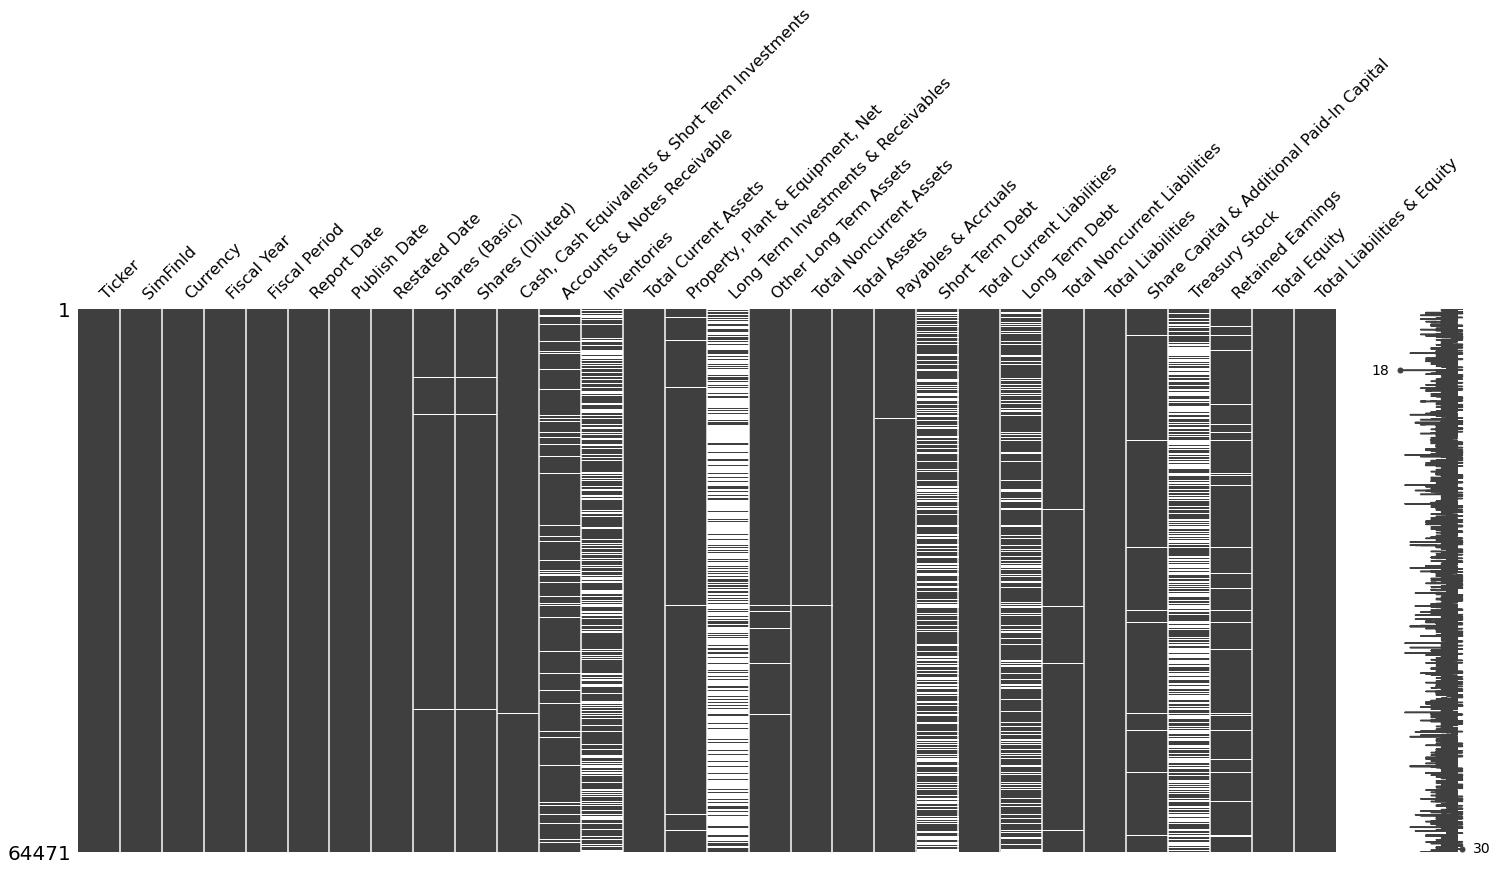

In [28]:
msno.matrix(df_balance);

### Cash Flow Statement

In [8]:
df_cashflow = pd.read_csv('../data/simfin/us-cashflow-quarterly.csv', 
                          delimiter=';', 
                          parse_dates=['Report Date', 'Publish Date', 'Restated Date'])
df_cashflow.head()

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period,Report Date,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),...,Net Cash from Operating Activities,Change in Fixed Assets & Intangibles,Net Change in Long Term Investment,Net Cash from Acquisitions & Divestitures,Net Cash from Investing Activities,Dividends Paid,Cash from (Repayment of) Debt,Cash from (Repurchase of) Equity,Net Cash from Financing Activities,Net Change in Cash
0,A,45846,USD,2010,Q3,2010-07-31,2010-10-06,2011-09-07,347000000.0,352000000.0,...,90000000.0,-27000000.0,30000000.0,-1.102000e+09,-1.112000e+09,NaN,7.470000e+08,-54000000.0,6.880000e+08,-329000000
1,A,45846,USD,2010,Q4,2010-10-31,2010-12-20,2012-12-20,344000000.0,356000000.0,...,373000000.0,-34000000.0,0.0,-1.400000e+07,-1.400000e+07,0.0,-2.900000e+07,-17000000.0,-4.600000e+07,332000000
2,A,45846,USD,2011,Q1,2011-01-31,2011-03-09,2012-03-05,347000000.0,355000000.0,...,120000000.0,-38000000.0,5000000.0,0.000000e+00,1.500000e+09,NaN,-1.500000e+09,-134000000.0,-1.634000e+09,-11000000
3,A,45846,USD,2011,Q2,2011-04-30,2011-06-07,2012-06-04,347000000.0,355000000.0,...,378000000.0,-51000000.0,9000000.0,-9.600000e+07,-1.260000e+08,0.0,0.000000e+00,68000000.0,6.800000e+07,337000000
4,A,45846,USD,2011,Q3,2011-07-31,2011-09-07,2012-09-05,348000000.0,357000000.0,...,252000000.0,-32000000.0,0.0,0.000000e+00,-3.200000e+07,0.0,0.000000e+00,-97000000.0,-9.700000e+07,126000000


In [9]:
df_cashflow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64471 entries, 0 to 64470
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Ticker                                     64471 non-null  object        
 1   SimFinId                                   64471 non-null  int64         
 2   Currency                                   64471 non-null  object        
 3   Fiscal Year                                64471 non-null  int64         
 4   Fiscal Period                              64471 non-null  object        
 5   Report Date                                64471 non-null  datetime64[ns]
 6   Publish Date                               64471 non-null  datetime64[ns]
 7   Restated Date                              64471 non-null  datetime64[ns]
 8   Shares (Basic)                             63932 non-null  float64       
 9   Shares (Diluted) 

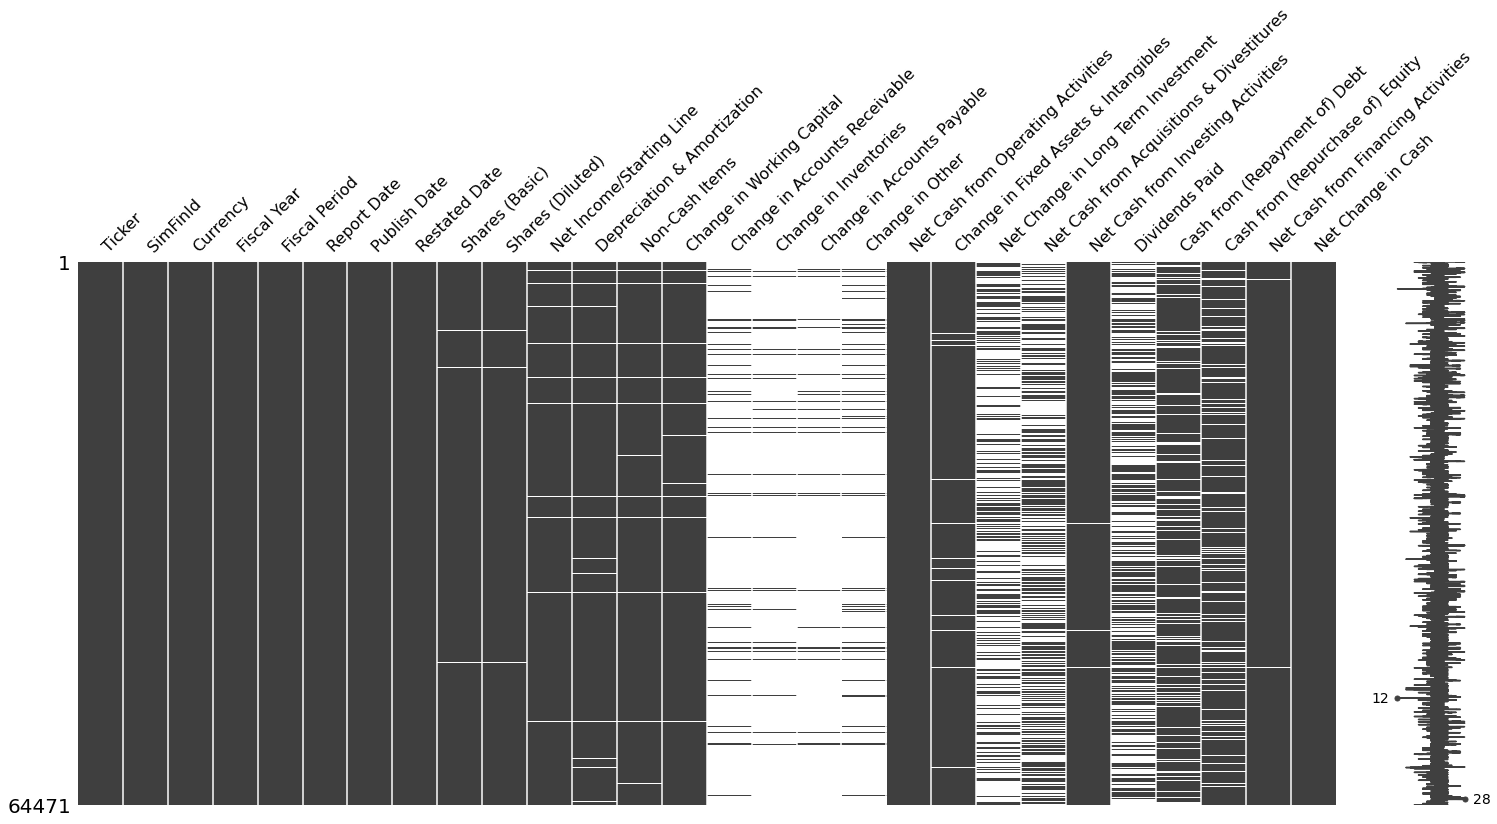

In [31]:
msno.matrix(df_cashflow);

## Merging Data

In [109]:
for i, ticker in enumerate(snp_tickers):
    # Manually catching 'BF.B'
    if ticker == 'BF.B':
        ticker = 'BF-B'
        
    # Setting dataframes
    prices = pd.read_csv(f'../data/price_histories/{ticker}_history.csv', parse_dates=['Date'])
    prices.rename(columns={'Date': 'Price Date'}, inplace=True)
    income = df_income[df_income.Ticker == ticker].set_index('Report Date')
    balance = df_balance[df_balance.Ticker == ticker].set_index('Report Date')
    cashflow = df_cashflow[df_cashflow.Ticker == ticker].set_index('Report Date')
    
    # Concatenating financials
    financials = pd.concat([income, balance, cashflow], axis=1).reset_index()
    
    # Dropping unnecessary columns
    to_drop = ['Ticker', 'SimFinId', 'Currency', 'Fiscal Year', 'Fiscal Period', 
               'Publish Date', 'Restated Date', 'Shares (Basic)', 'Shares (Diluted)']
    financials = financials.drop(columns=to_drop)
    
    # Merging in prices
    final_df = pd.merge_asof(left=financials,
                             right=prices,
                             left_on='Report Date', 
                             right_on='Price Date', 
                             direction='backward')
    
    # Exporting dataframe
    final_df.to_csv(f'../data/merged_data/{ticker}_merged.csv', index=False)
    
    # Printing progress
    print(f'{i+1}/{len(snp_tickers)} -- merged and saved {ticker.ljust(5)}', end='\r')
    

Loading in an example to ensure everything worked properly:

In [112]:
msft_merged = pd.read_csv('../data/merged_data/MSFT_merged.csv', parse_dates=['Report Date', 'Price Date'])
msft_merged

,Report Date,Revenue,Cost of Revenue,Gross Profit,Operating Expenses,"Selling, General & Administrative",Research & Development,Depreciation & Amortization,Operating Income (Loss),Non-Operating Income (Loss),...,Cash from (Repurchase of) Equity,Net Cash from Financing Activities,Net Change in Cash,Price Date,Open,High,Low,Close,Adj Close,Volume
0,2004-03-31,9.175000e+09,-1.411000e+09,7.764000e+09,-6.486000e+09,-4.948000e+09,-1.538000e+09,NaN,1.278000e+09,1.001000e+09,...,-1.040000e+09,-1.040000e+09,2800000000,2004-03-31,25.200001,25.200001,24.870001,24.930000,15.907083,70533200.0
1,2004-06-30,9.292000e+09,-1.361000e+09,7.931000e+09,-4.798000e+09,-3.183000e+09,-1.615000e+09,NaN,3.133000e+09,5.710000e+08,...,1.296000e+09,1.296000e+09,6436000000,2004-06-30,28.570000,28.799999,28.389999,28.559999,18.223272,83544400.0
2,2004-09-30,9.189000e+09,-1.405000e+09,7.784000e+09,-4.290000e+09,-2.760000e+09,-1.530000e+09,NaN,3.494000e+09,2.790000e+08,...,1.320000e+08,-7.380000e+08,-4842000000,2004-09-30,27.590000,27.790001,27.520000,27.650000,17.694681,71218000.0
3,2004-12-31,1.081800e+10,-1.875000e+09,8.943000e+09,-4.194000e+09,-2.773000e+09,-1.421000e+09,NaN,4.749000e+09,4.200000e+08,...,-1.740000e+08,-3.367200e+10,-5904000000,2004-12-31,26.750000,26.900000,26.680000,26.719999,19.058111,54959500.0
4,2005-03-31,9.620000e+09,-1.363000e+09,8.257000e+09,-4.928000e+09,-3.446000e+09,-1.482000e+09,NaN,3.329000e+09,4.960000e+08,...,-2.073000e+09,-2.958000e+09,224000000,2005-03-31,24.250000,24.309999,24.120001,24.170000,17.292517,62382300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,2019-06-30,3.371700e+10,-1.041200e+10,2.330500e+10,-1.090000e+10,-6.387000e+09,-4.513000e+09,NaN,1.240500e+10,1.910000e+08,...,-4.325000e+09,-8.011000e+09,144000000,2019-06-28,134.570007,134.600006,133.160004,133.960007,130.812180,30043000.0
62,2019-09-30,3.305500e+10,-1.040600e+10,2.264900e+10,-9.963000e+09,-5.398000e+09,-4.565000e+09,NaN,1.268600e+10,0.000000e+00,...,-4.485000e+09,-1.020900e+10,1761000000,2019-09-30,138.050003,139.220001,137.779999,139.029999,136.215134,17280900.0
63,2019-12-31,3.690600e+10,-1.235800e+10,2.454800e+10,-1.065700e+10,-6.054000e+09,-4.603000e+09,NaN,1.389100e+10,1.940000e+08,...,-4.972000e+09,-8.915000e+09,-4253000000,2019-12-31,156.770004,157.770004,156.449997,157.699997,155.032852,18369400.0
64,2020-03-31,3.502100e+10,-1.097500e+10,2.404600e+10,-1.107100e+10,-6.184000e+09,-4.887000e+09,NaN,1.297500e+10,-1.320000e+08,...,-6.717000e+09,-1.464500e+10,2846000000,2020-03-31,159.399994,164.779999,156.559998,157.710007,155.466171,77927200.0


In [113]:
msft_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 64 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Report Date                                      66 non-null     datetime64[ns]
 1   Revenue                                          66 non-null     float64       
 2   Cost of Revenue                                  66 non-null     float64       
 3   Gross Profit                                     66 non-null     float64       
 4   Operating Expenses                               66 non-null     float64       
 5   Selling, General & Administrative                66 non-null     float64       
 6   Research & Development                           66 non-null     float64       
 7   Depreciation & Amortization                      0 non-null      float64       
 8   Operating Income (Loss)                   

# Exploratory Data Analysis

# Data Preprocessing